In [1]:
import os
import re
from collections import Counter

import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import pollock

/miniconda/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [5]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

In [6]:
run_name = 'HTAN_breast_v9'
adata = sc.read_h5ad('/data/single_cell_classification/tumor/BR/raw/houxiang_brca/merged.h5ad')

malignant_cell_type = 'BR_Malignant'
cell_type_key = 'cell_type'
model_save_dir = os.path.join(MODEL_DIR, run_name)

In [7]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('BR_Malignant', 10137),
 ('Fibroblasts', 8305),
 ('CD4+ T-cells', 8001),
 ('CD8+ T-cells', 7080),
 ('Macrophages', 3585),
 ('B-cells', 3001),
 ('Endothelial cells', 2883),
 ('NK cells', 2053),
 ('Tregs', 1523),
 ('Plasma cells', 1445),
 ('Mast cells', 161),
 ('DC', 106)]

In [8]:
pds = pollock.PollockDataset(adata.copy(), cell_type_key=cell_type_key, n_per_cell_type=1000, batch_size=64,
                    dataset_type='training', min_genes=10, min_cells=3, mito_threshold=None,
                    max_n_genes=None, log=True, cpm=False, min_disp=None)

2020-06-04 14:44:26,767 normalizing counts for model training
2020-06-04 14:44:26,768 filtering by min genes: 10
2020-06-04 14:44:33,136 cells remaining after filter: 48280
2020-06-04 14:44:33,137 filtering by min cells: 3
2020-06-04 14:44:46,680 genes remaining after filter: 26912
2020-06-04 14:44:46,681 loging data
2020-06-04 14:44:54,693 scaling data
2020-06-04 14:45:20,571 creating tf datasets


In [13]:
pm = pollock.PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.0001, latent_dim=100)

In [14]:
pm.fit(pds, epochs=25)

2020-06-04 15:01:07,456 epoch: 1, train loss: 59.97040939331055, val loss: 78.80781555175781
2020-06-04 15:01:15,042 epoch: 2, train loss: 55.58197784423828, val loss: 70.41414642333984
2020-06-04 15:01:22,585 epoch: 3, train loss: 54.435157775878906, val loss: 69.63520812988281
2020-06-04 15:01:30,258 epoch: 4, train loss: 53.70466995239258, val loss: 68.67512512207031
2020-06-04 15:01:46,180 epoch: 5, train loss: 52.878639221191406, val loss: 67.82585144042969
2020-06-04 15:01:54,010 epoch: 6, train loss: 52.415985107421875, val loss: 67.3128433227539
2020-06-04 15:02:01,658 epoch: 7, train loss: 51.971282958984375, val loss: 66.8635025024414
2020-06-04 15:02:09,369 epoch: 8, train loss: 51.58826446533203, val loss: 66.33182525634766
2020-06-04 15:02:17,111 epoch: 9, train loss: 51.322784423828125, val loss: 66.10777282714844
2020-06-04 15:02:32,680 epoch: 10, train loss: 51.07176971435547, val loss: 65.90223693847656
2020-06-04 15:02:40,347 epoch: 11, train loss: 50.72399139404297, 

In [15]:
pm.save(pds, model_save_dir)

/miniconda/lib/python3.7/site-packages/numpy/lib/format.py:356: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


0.8780865819060628


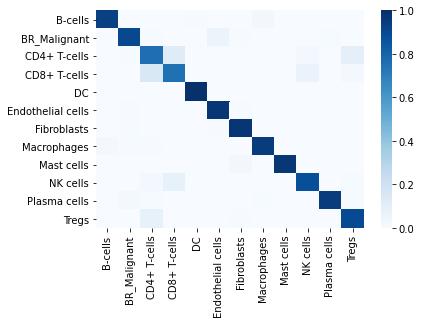

In [16]:
cdf = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
print(pm.summary['validation']['metrics']['accuracy'])
sns.heatmap(cdf, cmap='Blues')

In [17]:
pm.summary['model_parameters']

{'alpha': 0.0001,
 'learning_rate': 0.0001,
 'latent_dim': 100,
 'cell_types': ['B-cells',
  'BR_Malignant',
  'CD4+ T-cells',
  'CD8+ T-cells',
  'DC',
  'Endothelial cells',
  'Fibroblasts',
  'Macrophages',
  'Mast cells',
  'NK cells',
  'Plasma cells',
  'Tregs']}

In [18]:
pm.summary['history'].keys()

dict_keys(['train_losses', 'validation_losses', 'train_accuracies', 'validation_accuracies', 'cell_type_train_losses', 'cell_type_val_losses', 'cell_type_train_accuracies', 'cell_type_val_accuracies'])

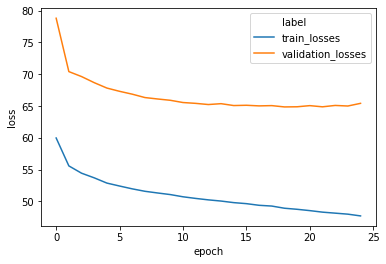

In [19]:
loss, label, epoch = [], [], []
for k in ['train_losses', 'validation_losses']:
    loss += pm.summary['history'][k]
    label += [k] * len(pm.summary['history'][k])
    epoch += list(range(len(pm.summary['history'][k])))
# pm.summary['history']['train_losses'] + pm.summary['history']['validation_losses']
df = pd.DataFrame.from_dict({
    'label': label,
    'loss': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='loss', data=df, hue='label')

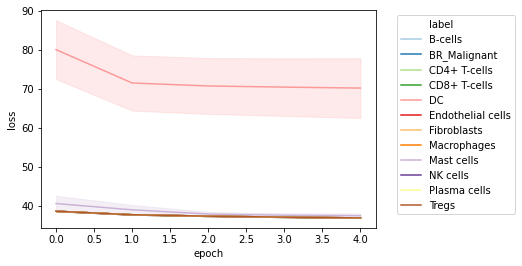

In [20]:
loss, label, epoch = [], [], []
for k in ['cell_type_train_losses', 'cell_type_val_losses']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'label': label,
    'loss': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='loss', data=df, hue='label',
            palette=sns.color_palette("Paired"))
plt.legend(bbox_to_anchor=(1.05, 1))

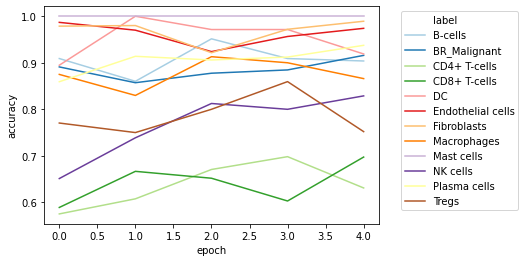

In [21]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_accuracies']:
    for cell_type, vals in pm.summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'label': label,
    'accuracy': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='accuracy', data=df, hue='label',
             palette=sns.color_palette("Paired"))
plt.legend(bbox_to_anchor=(1.05, 1))